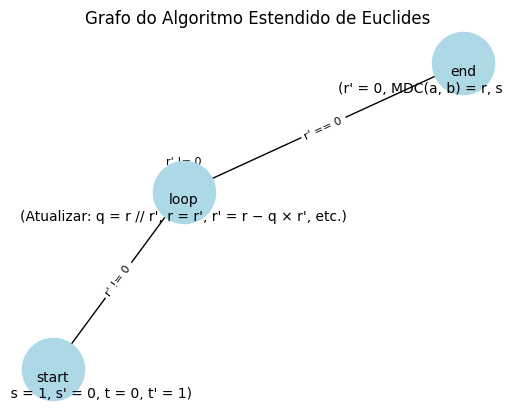

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

# Criar um grafo direcionado
G = nx.DiGraph()

# Definir os nós com as anotações (estado inicial e genérico)
nodes = [
    ("start", "r = a, r' = b, s = 1, s' = 0, t = 0, t' = 1"),
    ("loop", "Atualizar: q = r // r', r = r', r' = r − q × r', etc."),
    ("end", "r' = 0, MDC(a, b) = r, s e t prontos")
]

# Definir as arestas com as condições
edges = [
    ("start", "loop", "r' != 0"),
    ("loop", "loop", "r' != 0"),
    ("loop", "end", "r' == 0")
]

# Adicionar nós ao grafo
for label, annotation in nodes:
    G.add_node(label, annotation=annotation)

# Adicionar arestas ao grafo com as condições
for source, target, condition in edges:
    G.add_edge(source, target, condition=condition)

# Gerar as posições dos nós para visualização
pos = nx.spring_layout(G)

# Desenhar os nós
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=2000)

# Adicionar labels para os nós com as anotações
node_labels = {node: f"{node}\n({data['annotation']})" for node, data in G.nodes(data=True)}

# Ajustar a posição dos labels para evitar sobreposição
pos_labels = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=10)

# Desenhar as arestas
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)

# Adicionar labels para as condições nas arestas
edge_labels = {(source, target): data['condition'] for source, target, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Mostrar o grafo
plt.title("Grafo do Algoritmo Estendido de Euclides")
plt.axis("off")
plt.show()

In [33]:
from z3 import *

def weakest_precondition(Q, T):
    """Calcula a weakest precondition."""
    Q_sub = substitute(Q, [(T['r_next'], T['r_expr']),
                           (T['r_prime_next'], T['r_prime_expr']),
                           (T['s_next'], T['s_expr']),
                           (T['s_prime_next'], T['s_prime_expr']),
                           (T['t_next'], T['t_expr']),
                           (T['t_prime_next'], T['t_prime_expr'])])
    return And(Q_sub, T['condition'])

def strongest_postcondition(P, T):
    """Calcula a strongest postcondition."""
    fresh_vars = [Int(f"z{i}") for i in range(6)]  # Variáveis para (r, r', s, s', t, t')
    T_condition = And(P, T['condition'])
    return Exists(fresh_vars, And(T_condition,
                                  T['r_next'] == T['r_expr'],
                                  T['r_prime_next'] == T['r_prime_expr'],
                                  T['s_next'] == T['s_expr'],
                                  T['s_prime_next'] == T['s_prime_expr'],
                                  T['t_next'] == T['t_expr'],
                                  T['t_prime_next'] == T['t_prime_expr']))

# Transições do EXA
transitions = [
    {
        "condition": Int('r_prime') != 0,  # Enquanto r' != 0
        "r_next": Int('r_next'), "r_expr": Int('r_prime'),
        "r_prime_next": Int('r_prime_next'), "r_prime_expr": Int('r') - (Int('q') * Int('r_prime')),
        "s_next": Int('s_next'), "s_expr": Int('s_prime'),
        "s_prime_next": Int('s_prime_next'), "s_prime_expr": Int('s') - (Int('q') * Int('s_prime')),
        "t_next": Int('t_next'), "t_expr": Int('t_prime'),
        "t_prime_next": Int('t_prime_next'), "t_prime_expr": Int('t') - (Int('q') * Int('t_prime')),
    }
]

# Estado inicial
initial_predicate = And(Int('r') > 0, Int('r_prime') > 0, Int('s') == 1, Int('s_prime') == 0,
                        Int('t') == 0, Int('t_prime') == 1)

# Estado inseguro (exemplo: verificar se r < 0 durante a execução)
unsafe_state = Int('r') < 0

# Calculando Weakest Precondition e Strongest Postcondition
Q = unsafe_state
for T in transitions:
    Q = weakest_precondition(Q, T)

reachable_states = strongest_postcondition(initial_predicate, transitions[0])

# Verificar segurança
s = Solver()
s.add(And(reachable_states, Q))

if s.check() == sat:
    print("O programa não é seguro! Há estados inseguros alcançáveis.")
else:
    print("O programa é seguro.")


O programa é seguro.
